In [2]:
import os
os.environ['THEANO_FLAGS'] = 'device=gpu, floatX=float32'

In [3]:
import ssn_theano as ssn
reload(ssn)
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import cPickle as pickle
import rf_layer_LIF as rf_lif
import ks_test
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline

Using gpu device 0: GeForce GTX 680 (CNMeM is disabled, CuDNN not available)


In [4]:
# load Blasdel orientation and ocular dominance maps (previously processed,
# see map_analysis.ipynb
st = time.time()
[OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-13.p', 'rb')
print "Elapsed time to load maps: %d seconds" % (time.time() - st)
OD_map = OD_map_full[-75:,-75:]
OP_map = np.floor(OP_map_full[-75:,-75:])

Elapsed time to load maps: 0 seconds


In [5]:
# select some units:
n_units = 50
selected_units = ssn.select_random_units(n_units)
r_units = selected_units
N_pairs = 75
field_size = 16.
dx = 16./75

OD_prefs = np.zeros(len(selected_units))
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    OD_prefs[i] = OD_map[yi,xi]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Test interocular transfer with parameter variance, without OD bias


In [7]:
# NORMAL, unbiased network:
st = time.time()
ss_net = ssn.SSNetwork(ori_map=OP_map, ocd_map=OD_map)
print "Time to generate network: ", time.time()-st

Time to generate network:  11.0134990215


In [10]:
# Run this to get an idea of how long an individual simulation takes 
st = time.time()
c0 = 40
rE, rI = ss_net.run_simulation(c0,h_centre[0])
print "elapsed time: ",time.time()-st

elapsed time:  25.2245512009


# Hyperopt procedure

In [8]:
# Define objective funtion for hyperopt:
def iot_ssn_ks2d(args):
    sig_EE, sig_IE, sig_EI, sig_II, J_EE, J_IE, J_EI, J_II = args
    
    # Generate SSN with specified hyperparams:
    ss_net = ssn.SSNetwork(sig_EE, sig_IE, sig_EI, sig_II, J_EE, J_IE, J_EI, J_II, ori_map=OP_map, ocd_map=OD_map)
    
    # TODO: Check the stability of the network and abort if unstable (return high value)
    
    c0 = 40
    dt0 = 0.005
    timesteps = 100
    dx = ss_net.dx
    N_pairs = ss_net.N_pairs
    
    # Cast SSN variables to float32 for Theano:
    W_EE0 = ss_net.W_EE.astype('float32')
    W_EI0 = ss_net.W_EI.astype('float32')
    W_IE0 = ss_net.W_IE.astype('float32')
    W_II0 = ss_net.W_II.astype('float32')

    k0 = ss_net.k.astype('float32')
    n_E0 = ss_net.n_E.astype('float32')
    n_I0 = ss_net.n_I.astype('float32')

    tau_E0 = ss_net.tau_E.astype('float32')
    tau_I0 = ss_net.tau_I.astype('float32')
    
    # probe the monocular size tuning for the selected units and # find the SFS for each unit:
    dom_sfs_E = np.zeros(n_units)
    dom_sfs_I = np.copy(dom_sfs_E)
    sfs_fr_E = np.zeros(n_units)
    sfs_fr_I = np.copy(sfs_fr_E)
    stim_sizes = np.linspace(0.5,5,10)
    surround_outer_d = 10
    dom_size_tuning_results = np.zeros((n_units, len(stim_sizes)+1, 2))
    
    for i in range(n_units):
        sfs_found_E = False
        sfs_found_I = False
        xi = selected_units[i,0]
        yi = selected_units[i,1]
        ori = OP_map[yi,xi]
        ocularity = np.round(OD_prefs[i])
        for j in range(len(stim_sizes)):
            h0 = ssn.generate_ext_stimulus( ori, stim_sizes[j], [dx*xi, dx*yi], OP_map, OD_map, ocularity)
            r_E,r_I = ss_net.run_simulation(c0,h0)
                
            dom_size_tuning_results[i,j,0] = r_E[yi,xi]
            dom_size_tuning_results[i,j,1] = r_I[yi,xi] 
                          
            # check to see if any of the rates overflowed:
            if dom_size_tuning_results[i,j,0]>1000 or np.isnan(dom_size_tuning_results[i,j,0]):
                print "Network unstable, skipping!"
                return {
                    'status':'fail',
                    'loss':10000,
                    'attachments':{'msg':'Network was unstable (1)'}
                    }
            if dom_size_tuning_results[i,j,0] > sfs_fr_E[i]:
                sfs_fr_E[i] = dom_size_tuning_results[i,j,0]
                dom_sfs_E[i] = stim_sizes[j]
            else:
                sfs_found_E = True
                          
            if dom_size_tuning_results[i,j,1] > sfs_fr_I[i]:
                sfs_fr_I[i] = dom_size_tuning_results[i,j,1]
                dom_sfs_I[i] = stim_sizes[j]
            else:
                sfs_found_I = True
            
#             if sfs_found_E and sfs_found_I:
#                 break
            if sfs_found_E:
                break
    
    # probe the dominant eye surround suppression:
    for i in range(n_units):
        xi = selected_units[i,0]
        yi = selected_units[i,1]
        ori = OP_map[yi,xi]
        ocularity = np.round(OD_prefs[i])
        h0 = ssn.generate_ext_stimulus( ori, surround_outer_d, [dx*xi, dx*yi], OP_map, OD_map, ocularity)
        r_E, r_I = ss_net.run_simulation(c0,h0)
        dom_size_tuning_results[i,-1,0] = r_E[yi,xi]
        dom_size_tuning_results[i,-1,1] = r_I[yi,xi] 
                          
    # Now probe the non dominant stimuli (surround only)
    non_dom_surround_results = np.zeros((n_units, 2))
    for i in range(n_units):
        xi = selected_units[i,0]
        yi = selected_units[i,1]
        ori = OP_map[yi,xi]
        dom_ocu = np.round(OD_prefs[i])
        nd_ocu = np.abs(dom_ocu-1)
        centre = ssn.generate_ext_stimulus( ori, dom_sfs_E[i], [dx*xi, dx*yi], OP_map, OD_map, dom_ocu )
        surround = ssn.generate_ring_stimulus( ori, dom_sfs_E[i], surround_outer_d, [dx*xi, dx*yi], nd_ocu, OP_map, OD_map)
        h0 = centre + surround
        r_E,r_I = ss_net.run_simulation(c0,h0)

        non_dom_surround_results[i,0] = r_E[yi,xi]
        non_dom_surround_results[i,1] = r_I[yi,xi] 
#         if dom_sfs_E[i]==dom_sfs_I[i]:
#             non_dom_surround_results[i,1] = r_I.get_value()[yi,xi] 
#         else:
#             r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
#             r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
#             centre = ssn.generate_ext_stimulus( ori, dom_sfs_I[i], [dx*xi, dx*yi], OP_map, OD_map, dom_ocu )
#             surround = ssn.generate_ring_stimulus( ori, dom_sfs_I[i], surround_outer_d, [dx*xi, dx*yi], nd_ocu, OP_map, OD_map)
#             h0 = centre + surround    
#             for t in range(timesteps):
#                 euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)  
#             non_dom_surround_results[i,1] = r_I.get_value()[yi,xi]
                          
    dom_SI_E = (sfs_fr_E - dom_size_tuning_results[:,-1,0])/sfs_fr_E
    non_dom_SI_E = (sfs_fr_E - non_dom_surround_results[:,0])/sfs_fr_E
    dom_SI_I = (sfs_fr_I - dom_size_tuning_results[:,-1,1])/sfs_fr_I
    non_dom_SI_I = (sfs_fr_I - non_dom_surround_results[:,1])/sfs_fr_I                          
    
    # Concatenate the E and I results
#     model_data_x = np.concatenate((dom_SI_E, dom_SI_I))
#     model_data_y = np.concatenate((non_dom_SI_E, non_dom_SI_I))
    
    model_data_x = dom_SI_E
    model_data_y = non_dom_SI_E

    deangelis_data = np.array([[42.711, 21.488],
                            [44.588, 24.483],
                            [44.999, 31.508],
                            [58.885, 42.252],
                            [56.048, 57.955],
                            [64.901, 85.434],
                            [75.685, 65.186],
                            [79.023, 70.455],
                            [84.173, 42.045],
                            [98.365, 60.537],
                            [98.224, 95.248],
                            [82.045, 78.616],
                            [81.002, 76.550]])
    deangelis_data = deangelis_data/100
    
    d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], model_data_x, model_data_y)
    
    if prob == 1:
        print "KS test failed to converge, returning error!"
        return {
            'status':'fail',
            'loss':10000,
            'attachments':{'msg':'Network was unstable (1)',
                          'units_probed':pickle.dumps([selected_units,sfs_fr_E,sfs_fr_I,dom_size_tuning_results,non_dom_surround_results])}
            }
    
    return {
        'status': 'ok',
        'loss': 1-prob,
        'attachments': {'units_probed':pickle.dumps([selected_units,sfs_fr_E,sfs_fr_I,dom_size_tuning_results,non_dom_surround_results])}
        }

In [9]:
# Define Hyperopt search space:
space = [hp.uniform('sig_EE',7,9), 
         hp.uniform('sig_IE',10,16), 
         hp.uniform('sig_EI',3,5),
         hp.uniform('sig_II',3,5),
         hp.uniform('J_EE',0.09,0.105),
         hp.uniform('J_IE',0.35,0.45),
         hp.uniform('J_EI',0.089,0.105),
         hp.uniform('J_II',0.08,0.105)]

In [10]:
# create a Trials database to store experiment results:
trials = Trials()

In [ ]:
st = time.time()
evals = 50
best = fmin(iot_ssn_ks2d, space, algo=tpe.suggest, max_evals=evals, trials=trials)
print "Elapsed time for %d hyperopt sims: %d minutes." % (evals, (time.time()-st)/60.)
print 'tpe:', best
print "Best p-value: ", 1-np.min(trials.losses())

In [ ]:
bad_ind = np.argmin(trials.losses())

In [39]:
trials.losses()[bad_ind] = 10000

In [50]:
print "Total trials: %d" % (len(trials.losses()))
print "P values (sorted):"
print 1-np.array(trials.losses())


Total trials: 50
P values (sorted):
[  4.03261774e-03   3.78128765e-02   2.44795155e-02   2.14106688e-03
   5.49125264e-04   2.50070211e-04   5.11114997e-03   2.74267358e-02
   3.53647661e-02   5.72227682e-02   5.50099636e-04   1.49817322e-02
   2.70091382e-03   7.60677373e-03   1.68758956e-03   5.29466016e-03
   1.16964804e-01   1.00000000e+00   3.07183126e-04   1.69280241e-01
   2.05285149e-02   2.55130829e-02   1.60346323e-01   9.39017298e-03
   9.79715098e-02   1.22633721e-02   7.48840727e-02   1.60298983e-01
   4.27649782e-02   1.49912878e-02   6.68464109e-04   1.22513477e-02
   9.96422201e-03   1.50079181e-01   7.29641591e-02   1.14596863e-02
   2.90423597e-02   7.09290906e-04   3.76535046e-03   1.49952762e-02
   3.89182868e-02   1.49952327e-02   1.02790357e-01   4.57455809e-05
   2.90390722e-02   9.37466892e-03   1.16436061e-03   7.95724852e-02
   1.64778844e-04   1.22499491e-01]


In [ ]:
deangelis_data = np.array([[42.711, 21.488],
                            [44.588, 24.483],
                            [44.999, 31.508],
                            [58.885, 42.252],
                            [56.048, 57.955],
                            [64.901, 85.434],
                            [75.685, 65.186],
                            [79.023, 70.455],
                            [84.173, 42.045],
                            [98.365, 60.537],
                            [98.224, 95.248],
                            [82.045, 78.616],
                            [81.002, 76.550]])
deangelis_data = deangelis_data/100

In [53]:
webb_data = np.array([[0.3538, 0.3214],
    [0.5513, 0.2271],
    [0.5154, 0.5064],
    [0.5641, 0.5681],
    [0.6077, 0.5605],
    [0.7179, 0.6172],
    [0.7487, 0.6865],
    [0.8282, 0.6406],
    [0.8923, 0.5459],
    [0.9282, 0.5690],
    [0.6308, 0.4093],
    [0.7385, 0.4557],
    [0.7923, 0.4866],
    [0.7385, 0.5352],
    [0.9974, 0.9846]])

comp_data = np.concatenate( (deangelis_data, webb_data), axis=0 )

In [54]:
p_values = np.zeros(len(trials))
comp_p_values = np.copy(p_values)
for i in range(len(trials)):
    trial_results = trials.trial_attachments(trials.trials[i])['units_probed']
    [selected_units,sfs_fr_E,sfs_fr_I,dom_size_tuning_results,non_dom_surround_results] = pickle.loads(trial_results)
    dom_SI_E = (sfs_fr_E - dom_size_tuning_results[:,-1,0])/sfs_fr_E
    non_dom_SI_E = (sfs_fr_E - non_dom_surround_results[:,0])/sfs_fr_E
    dom_SI_I = (sfs_fr_I - dom_size_tuning_results[:,-1,1])/sfs_fr_I
    non_dom_SI_I = (sfs_fr_I - non_dom_surround_results[:,1])/sfs_fr_I
    
    d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_E, non_dom_SI_E)
    p_values[i] = prob
    
    d, prob = ks_test.ks2d2s(comp_data[:,0], comp_data[:,1], dom_SI_E, non_dom_SI_E)
    comp_p_values[i] = prob
    
print "E units only p-values: ", comp_p_values
print "Largest p value: %5.5f at trial %d"  % (np.max(comp_p_values), np.argmax(comp_p_values))

Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirno

In [57]:
comp_p_values[comp_p_values==1.] = 0
best_ind = np.argmax(comp_p_values)

In [59]:
p_values_I = np.zeros(len(trials))
comp_p_values_I = np.copy(p_values_I)
for i in range(len(trials)):
    trial_results = trials.trial_attachments(trials.trials[i])['units_probed']
    [selected_units,sfs_fr_E,sfs_fr_I,dom_size_tuning_results,non_dom_surround_results] = pickle.loads(trial_results)
    dom_SI_I = (sfs_fr_I - dom_size_tuning_results[:,-1,1])/sfs_fr_I
    non_dom_SI_I = (sfs_fr_I - non_dom_surround_results[:,1])/sfs_fr_I
    
    d, prob = ks_test.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_I, non_dom_SI_I)
    p_values_I[i] = prob
    
    d, prob = ks_test.ks2d2s(comp_data[:,0], comp_data[:,1], dom_SI_I, non_dom_SI_I)
    comp_p_values_I[i] = prob
    
print "I units only p-values: ", comp_p_values_I
print "Largest p value: %5.5f at trial %d"  % (np.max(comp_p_values), np.argmax(comp_p_values_I))

comp_p_values[comp_p_values==1.] = 0
best_ind = np.argmax(comp_p_values)

Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirnov test!
Running a 2D, 2 sample Kolmogorov-Smirno

In [60]:
print "E units p-value: ", comp_p_values[best_ind]
print "I units p-value: ", comp_p_values_I[best_ind]

E units p-value:  0.241767974676
I units p-value:  8.31027660996e-13


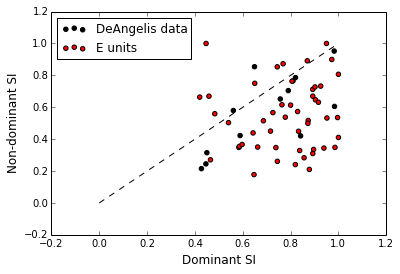

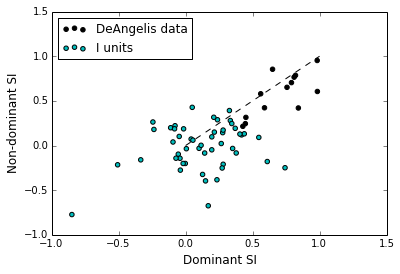

In [58]:
best_results = trials.trial_attachments(trials.trials[best_ind])['units_probed']
[selected_units,sfs_fr_E,sfs_fr_I,dom_size_tuning_results,non_dom_surround_results] = pickle.loads(best_results)
dom_SI_E = (sfs_fr_E - dom_size_tuning_results[:,-1,0])/sfs_fr_E
non_dom_SI_E = (sfs_fr_E - non_dom_surround_results[:,0])/sfs_fr_E
dom_SI_I = (sfs_fr_I - dom_size_tuning_results[:,-1,1])/sfs_fr_I
non_dom_SI_I = (sfs_fr_I - non_dom_surround_results[:,1])/sfs_fr_I

plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
plt.scatter(dom_SI_E, non_dom_SI_E, c='r', label='E units')
plt.plot([0,1], [0,1], 'k--')
# plt.axis([0,1,0,1])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.legend(loc='best')

plt.savefig('thesis_results/hyperopt_iot2_E.eps', dpi=1000)

plt.figure()
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label='DeAngelis data')
plt.scatter(dom_SI_I, non_dom_SI_I, c='c', label='I units')
plt.plot([0,1], [0,1], 'k--')
# plt.axis([0,1,0,1])
plt.xlabel('Dominant SI', fontsize=12)
plt.ylabel('Non-dominant SI', fontsize=12)
plt.legend(loc='best')
plt.savefig('thesis_results/hyperopt_iot2_I.eps', dpi=1000)


In [67]:
print trials.trials[best_ind]['misc']['vals']

{'sig_EE': [8.917922474635148], 'bias': [0.040052863631182135], 'sig_EI': [4.868446683799637], 'J_II': [0.08414954800729986], 'sig_IE': [14.519469044806234], 'sig_II': [3.9819247750475304], 'J_IE': [0.37916806507237083], 'J_EE': [0.09308493106580851], 'J_EI': [0.09300419500759669]}
